In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell

# For LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# For Arima
import pmdarima as pm

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100
warnings.filterwarnings('ignore')


<h4>Importing Datasets</h4>

In [89]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [90]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [91]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [92]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [93]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [94]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [95]:
# Accessing the highest count in the each keypouch, new and old.
sel_country = old_df[1]
print(sel_country)


sel_df = filtered_dataframe1[sel_country]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[sel_country]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600140,CTNR010050700496,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
1,ECS01050600140,CTNR010050700495,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
2,ECS010050700037,CTNR010050700657,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-21,40,HC,2300.0
3,ECS01050600141,CTNR010050700808,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-26,40,HC,2200.0
4,ECS01050600042,CTNR010050700971,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-29,40,HC,2600.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1683,ECS010230100188,010000371218,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-09,40,HC,1500.0
1684,ECS010230100390,010000377561,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-14,40,HC,1500.0
1685,ECS010230100390,010000371211,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-14,40,HC,1500.0
1686,ECS010230100462,010000390201,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-21,40,HC,1500.0
1687,ECS010230100462,010000377408,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-21,40,HC,1500.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 0 to 1687
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1688 non-null   object        
 1   CNTR_ID     1688 non-null   object        
 2   POD_ID      1688 non-null   object        
 3   ETD_POL_D   1688 non-null   object        
 4   PARTY_ID    1688 non-null   object        
 5   PARTY_NAME  1688 non-null   object        
 6   POD         1688 non-null   datetime64[ns]
 7   CNTR_SIZE   1688 non-null   object        
 8   CNTR_TYPE   1688 non-null   object        
 9   RATE        1688 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600140,CTNR010050700496,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
1,ECS01050600140,CTNR010050700495,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
2,ECS010050700037,CTNR010050700657,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-21,40,HC,2300.0
3,ECS01050600141,CTNR010050700808,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-26,40,HC,2200.0
4,ECS01050600042,CTNR010050700971,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-29,40,HC,2600.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1699,ECS010230200029,010000495920,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-04-23,40,HC,664.0
1700,ECS010230400101,010000535699,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-02,40,HC,350.0
1701,ECS010230300066,010000515298,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-02,40,HC,264.0
1702,ECS010230300067,010000550266,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0
1703,ECS010230300067,010000535541,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704 entries, 0 to 1703
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1704 non-null   object        
 1   CNTR_ID     1704 non-null   object        
 2   POD_ID      1704 non-null   object        
 3   ETD_POL_D   1704 non-null   object        
 4   PARTY_ID    1704 non-null   object        
 5   PARTY_NAME  1704 non-null   object        
 6   POD         1704 non-null   datetime64[ns]
 7   CNTR_SIZE   1704 non-null   object        
 8   CNTR_TYPE   1704 non-null   object        
 9   RATE        1704 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 146.4+ KB


<h2>Data Preprocessing</h2>

In [96]:
from sklearn.preprocessing import RobustScaler

# Select features
sel_feat = ['POD','RATE']
robust_df = sel_df[sel_feat].copy()  # make a copy to avoid SettingWithCopyWarning

# Robust Scaling
scaler = RobustScaler()
robust_df.loc[:, 'RATE'] = scaler.fit_transform(robust_df[['RATE']])
robust_df.head()

,POD,RATE
0,2005-07-19,1.204545
1,2005-07-19,1.204545
2,2005-07-21,1.318182
3,2005-07-26,1.204545
4,2005-07-29,1.659091


In [97]:
# Check if the DataFrame has any NaN values
if robust_df.isna().any().any():
    print("The DataFrame contains NaN values.")
else:
    print("The DataFrame does not contain NaN values.")

The DataFrame does not contain NaN values.


<h4>Interpolate missing values in between dates</h4>

In [98]:
# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')  

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

# Now we need to inverse the scaling
df_interpolated['RATE'] = scaler.inverse_transform(df_interpolated[['RATE']])

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-07-19,2200.40
1,2005-07-20,2249.68
2,2005-07-21,2299.84
3,2005-07-22,2279.60
4,2005-07-23,2260.24


,POD,RATE
6447,2023-02-17,1499.92
6448,2023-02-18,1499.92
6449,2023-02-19,1499.92
6450,2023-02-20,1499.92
6451,2023-02-21,1499.92


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6452 entries, 0 to 6451
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6452 non-null   datetime64[ns]
 1   RATE    6452 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 151.2 KB


<h4>Grouping it to week</h4>

In [99]:
from scipy import stats

# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate trimmed mean of RATE values
    rate_metric = stats.trim_mean(group_df['RATE'].dropna().values, 0.1) # trimming 10% from each end

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


,YearMonthWeek,Rate
0,2005-07-18,2254.96
1,2005-07-25,2388.59
2,2005-08-01,2261.37
3,2005-08-08,2203.17
4,2005-08-15,2253.58
5,2005-08-22,2252.07
6,2005-08-29,2252.45
7,2005-09-05,2220.51
8,2005-09-12,2200.40
9,2005-09-19,2200.40


,YearMonthWeek,Rate
903,2022-11-07,5145.51
904,2022-11-14,5877.42
905,2022-11-21,5404.61
906,2022-11-28,4232.45
907,2022-12-05,3433.28
908,2022-12-12,3672.86
909,2022-12-19,4012.07
910,2022-12-26,4164.31
911,2023-01-02,3006.86
912,2023-01-09,2687.54


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  918 non-null    datetime64[ns]
 1   Rate           918 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.5 KB


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [100]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200255,010000421246,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-03-10,40,HC,1100.0
1,ECS010230200255,010000410650,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-03-10,40,HC,1100.0
2,ECS010230100273,010000423692,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-03-14,40,HC,986.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
13,ECS010230300066,010000515298,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-02,40,HC,264.0
14,ECS010230300067,010000550266,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0
15,ECS010230300067,010000535541,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      16 non-null     object        
 1   CNTR_ID     16 non-null     object        
 2   POD_ID      16 non-null     object        
 3   ETD_POL_D   16 non-null     object        
 4   PARTY_ID    16 non-null     object        
 5   PARTY_NAME  16 non-null     object        
 6   POD         16 non-null     datetime64[ns]
 7   CNTR_SIZE   16 non-null     object        
 8   CNTR_TYPE   16 non-null     object        
 9   RATE        16 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.4+ KB


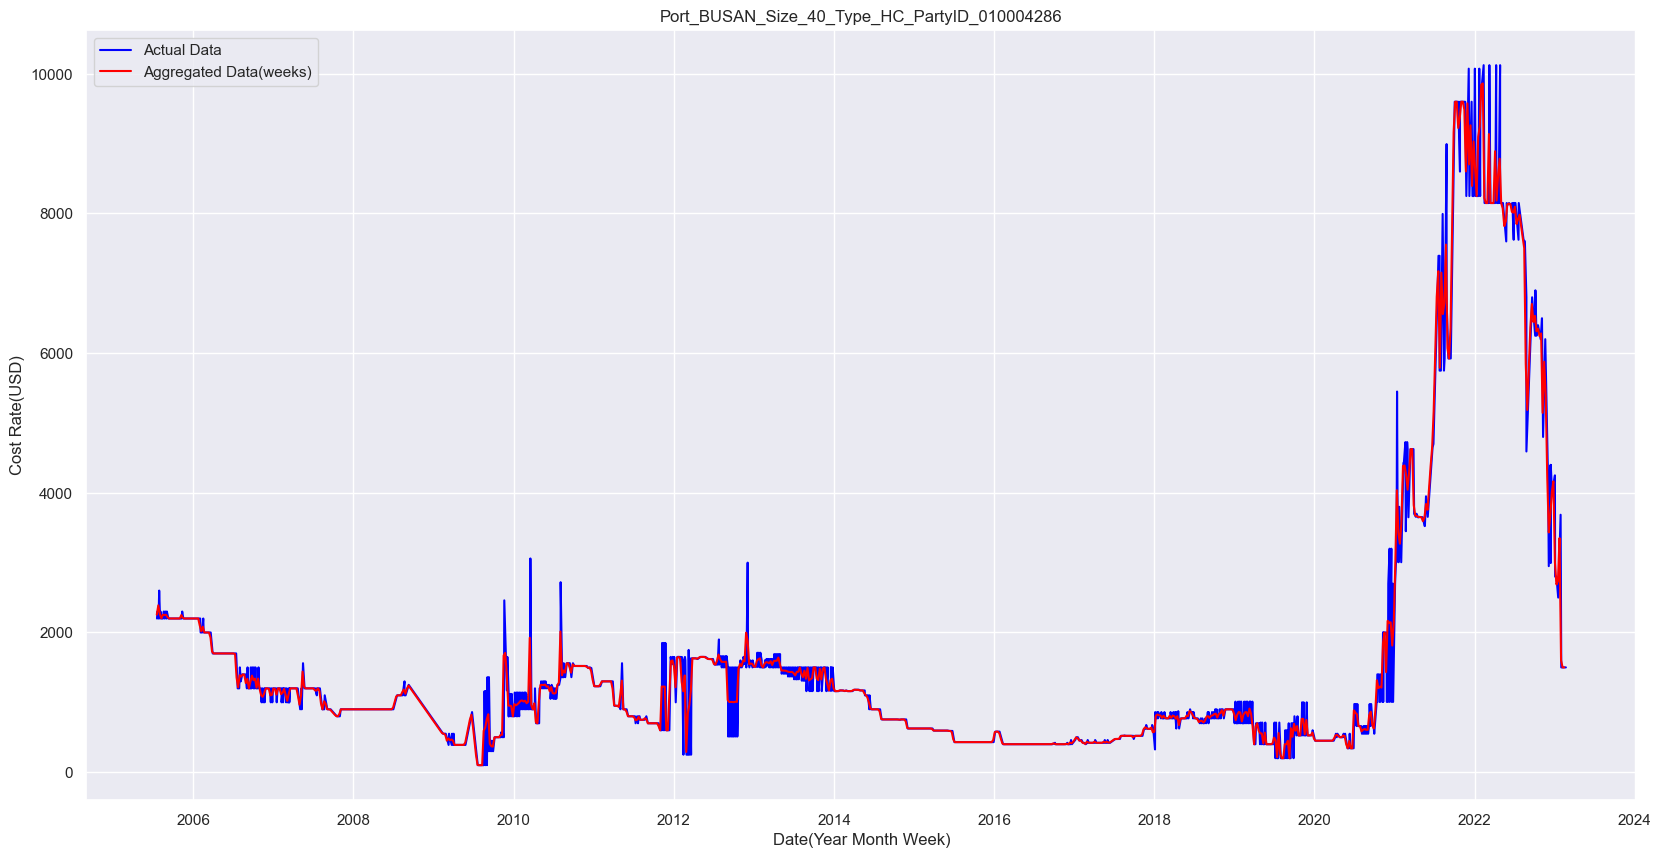

In [101]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

<h2>Iterative Nested Forecasting</h2>

<h4>Time series pipeline for best forecasting model to each dataframe</h4>

In [102]:
# General Functions

# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def plot_train_val_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()


<h4>LSTM</h4>

In [103]:
# Update create_dataset to handle multi-feature dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers):
    model = Sequential()

    # input layer
    model.add(Bidirectional(LSTM(lstm_layers[0], return_sequences=True),
                            input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(0.2))

    # hidden layers
    for i in range(1, len(lstm_layers)):
        model.add(Bidirectional(
            LSTM(lstm_layers[i], return_sequences=(i != (len(lstm_layers)-1)))))

    # output layer
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(trainX, trainY, epochs=epochs, validation_data=(testX, testY),
                        callbacks=[EarlyStopping(
                            monitor='val_loss', patience=10)],
                        verbose=2, shuffle=False)

    return model, history


def LSTM_Execute(trainX, testY):
    # Reshape into X=t and Y=t+1, timestep  look_back
    global look_back
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
    testX = np.reshape(testX, (testX.shape[0], look_back, 1))


    epochs_list = [100]

    lstm_layers_list = [
        [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
        [32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
        [16, 16, 8, 8, 4, 4, 2, 2],
        [8, 8, 4, 4, 2, 2],
        [4, 4, 2, 2],
        [2, 2]
    ]

    rmse_results = {}

    for epochs in epochs_list:
        print(f'Training for {epochs} epochs...')

        for lstm_layers in lstm_layers_list:
            print(f'Training with LSTM layers: {lstm_layers}')
            model, history = create_LSTM_model(
                trainX, trainY, testX, testY, epochs, lstm_layers)

            # Add the loss for this model to the plot
            plt.plot(
                history.history['loss'], label=f'Train Loss - {epochs} epochs, layers: {lstm_layers}')
            plt.plot(
                history.history['val_loss'], label=f'Validation Loss - {epochs} epochs, layers: {lstm_layers}')

            # Evalute LSTM Model
            trainPredict = model.predict(trainX)
            testPredict = model.predict(testX)

            # inverse_transform
            trainPredict = scaler.inverse_transform(trainPredict)
            trainY_orig = scaler.inverse_transform([trainY])
            testPredict = scaler.inverse_transform(testPredict)
            testY_orig = scaler.inverse_transform([testY])

            # Calculate mean squared error
            trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:, 0])
            print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
            testScore = calculate_RMSE(testY_orig[0], testPredict[:, 0])
            print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

            rmse_results[f'{epochs} epochs, {lstm_layers} layers'] = {
                'Train RMSE': trainScore, 'Test RMSE': testScore}

    # Configure and show the plot
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    print('\n\n\n')  # print some blank lines for separation

    # Convert the dictionary to a DataFrame for easy display
    rmse_df = pd.DataFrame(rmse_results).T
    print(rmse_df)
    return model, trainScore, testScore


<h4>Arima</h4>

In [104]:
# Function to execute Auto ARIMA model
def ARIMA_Execute(train, test):
    # Fit an auto_arima model
    arima_model = pm.auto_arima(train, start_p=1, start_q=1,
                                max_p=5, max_q=5, m=12,
                                start_P=0, seasonal=False,
                                d=0, D=0, trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)  # set to stepwise

    # Print the summary of the model
    print(arima_model.summary())

    # Forecast
    train_forecast = arima_model.predict_in_sample()
    test_forecast = arima_model.predict(n_periods=len(test))

    # Calculate the RMSE
    RMSE_ARIMA_train = np.sqrt(mean_squared_error(train, train_forecast))
    print("Train RMSE: %.3f" % RMSE_ARIMA_train)
    RMSE_ARIMA_test = np.sqrt(mean_squared_error(test, test_forecast))
    print("Test RMSE: %.3f" % RMSE_ARIMA_test)

    return arima_model, RMSE_ARIMA_train, RMSE_ARIMA_test


Key: Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136
Training for 100 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/100
20/20 - 44s - loss: 0.1783 - val_loss: 3.2240 - 44s/epoch - 2s/step
Epoch 2/100
20/20 - 1s - loss: 0.0940 - val_loss: 2.7598 - 700ms/epoch - 35ms/step
Epoch 3/100
20/20 - 1s - loss: 0.0524 - val_loss: 2.6408 - 694ms/epoch - 35ms/step
Epoch 4/100
20/20 - 1s - loss: 0.0458 - val_loss: 2.6752 - 685ms/epoch - 34ms/step
Epoch 5/100
20/20 - 1s - loss: 0.0465 - val_loss: 2.6873 - 691ms/epoch - 35ms/step
Epoch 6/100
20/20 - 1s - loss: 0.0470 - val_loss: 2.6838 - 682ms/epoch - 34ms/step
Epoch 7/100
20/20 - 1s - loss: 0.0469 - val_loss: 2.6819 - 678ms/epoch - 34ms/step
Epoch 8/100
20/20 - 1s - loss: 0.0469 - val_loss: 2.6820 - 676ms/epoch - 34ms/step
Epoch 9/100
20/20 - 1s - loss: 0.0468 - val_loss: 2.6821 - 696ms/epoch - 35ms/step
Epoch 10/100
20/20 - 1s - loss: 0.0468 - val_loss: 2.6819 - 677ms/epoch - 34ms/step
Epoch 11/100
20/20 - 1s

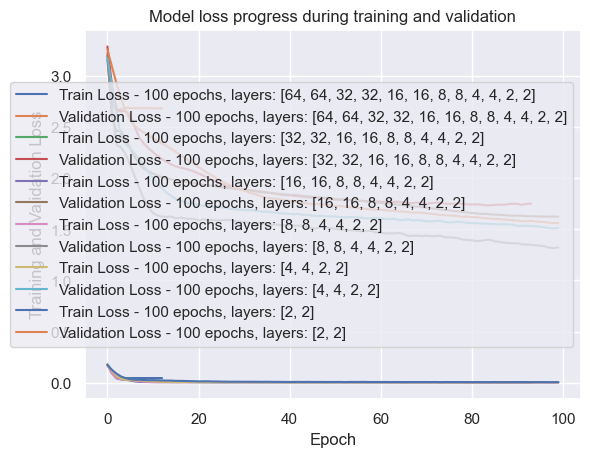





                                                    Train RMSE    Test RMSE
100 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4...  487.294629  3747.411353
100 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] ...  136.699421  3027.747793
100 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers       138.400658  2915.224384
100 epochs, [8, 8, 4, 4, 2, 2] layers               157.113627  2632.418103
100 epochs, [4, 4, 2, 2] layers                     154.993604  2815.252618
100 epochs, [2, 2] layers                           172.102298  2859.249006
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8090.851, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10863.427, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10082.603, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8064.911, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]          

In [105]:
# Normalize dataset for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the train dataset
train_size = int(len(agg_df) * 0.7)
train_data = agg_df['Rate'].values[:train_size].reshape(-1, 1)
test_data = agg_df['Rate'].values[train_size:].reshape(-1, 1)
train = scaler.fit_transform(train_data)

# Only transform the test dataset
test = scaler.transform(test_data)

# Initialize a dictionary for the current key
results_dict = {}

print(f"Key: {sel_country}")

# Run LSTM model
look_back = 5
model, LSTM_train_rmse, LSTM_test_rmse = LSTM_Execute(train, test)
results_dict[sel_country] = {'LSTM': {'model': model, 'Train RMSE': LSTM_train_rmse, 'Test RMSE': LSTM_test_rmse}}

# Run ARIMA model
model, ARIMA_train_rmse, ARIMA_test_rmse = ARIMA_Execute(train_data, test_data)
results_dict[sel_country]['ARIMA'] = {'model': model, 'Train RMSE': ARIMA_train_rmse, 'Test RMSE': ARIMA_test_rmse}

# Now you can directly fetch your results using sel_country as the key
results = results_dict[sel_country]
best_model_name, best_model_results = min(results.items(), key=lambda x: x[1]['Test RMSE'])
print(f"Key: {sel_country}, Best Model: {best_model_name}, Train RMSE: {best_model_results['Train RMSE']}, Test RMSE: {best_model_results['Test RMSE']}")


<h2>Forecasting with best model</h2>

In [106]:
# Add check for 'RATE_actual' values to avoid division by zero
def compute_accuracy(row):
    if row['RATE_actual'] == 0:
        return np.nan
    else:
        error = abs(row['RATE_actual'] - row['RATE_forecasted'])
        error_proportion = error / row['RATE_actual']
        return (1 - error_proportion) * 100


def forecast_next_weeks(model, look_back, scaler, last_values, n_weeks):
    forecast = []
    for _ in range(n_weeks):
        # Reshape last_values to 2D array with one feature
        last_values_2d = np.array(last_values[-look_back:]).reshape(-1, 1)

        # Scale the last_values_2d to be between 0 and 1
        input_values_scaled = scaler.transform(last_values_2d)

        # Reshape input to be [samples, time steps, features]
        input_values_scaled = input_values_scaled.reshape((1, look_back, 1))

        # Predict the next value
        prediction = model.predict(input_values_scaled)

        # Rescale the prediction back to the original scale
        prediction_rescaled = scaler.inverse_transform(prediction)

        # Append the predicted value to the forecast list
        forecast.append(prediction_rescaled[0][0])

        # Append the predicted value to the last_values list to be used as input for the next prediction
        last_values.append(prediction_rescaled[0][0])
        # Drop the first value in the last_values list
        last_values.pop(0)

    return forecast


In [107]:
weeks = 12

# Check if the best model is LSTM or ARIMA and perform the forecasting
if best_model_name == 'LSTM':
    # The best model for this key is the LSTM
    # Fetch the model
    best_model = results['LSTM']['model']

    # Use the model to make forecasts
    last_values = list(agg_df['Rate'].values[-look_back:])
    forecasted_values = forecast_next_weeks(
        best_model, look_back, scaler, last_values, weeks)

elif best_model_name == 'ARIMA':
    # The best model for this key is the ARIMA
    # Fetch the model
    best_model = results['ARIMA']['model']

    # Use the model to make forecasts
    forecasted_values = best_model.predict(n_periods=weeks)

else:
    # Unknown model
    print(f"Unknown model: {best_model_name}")

# Ensure that 'YearMonthWeek' is a datetime object
agg_df['YearMonthWeek'] = pd.to_datetime(agg_df['YearMonthWeek'])
last_date = agg_df['YearMonthWeek'].iloc[-1]

forecasted_dates = pd.date_range(
    start=last_date, periods=weeks+1, freq='W')[1:]

df_forecasted = pd.DataFrame({
    'POD': forecasted_dates,
    'RATE': forecasted_values
})

df_forecasted["RATE"] = df_forecasted["RATE"].round(2)
df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()

1/1 [==============================] - 0s 22ms/step


,POD,RATE
0,2023-02-26,2044.140015
1,2023-03-05,1885.239990
2,2023-03-12,1616.709961
3,2023-03-19,1647.579956
4,2023-03-26,1702.089966


,POD,RATE
7,2023-04-16,1633.410034
8,2023-04-23,1647.250000
9,2023-04-30,1651.619995
10,2023-05-07,1640.619995
11,2023-05-14,1616.359985


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     12 non-null     datetime64[ns]
 1   RATE    12 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 272.0 bytes


<h4>Comparing with actual updated against forecasted</h4>

In [108]:
comparison_df = pd.DataFrame(columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual'])
df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')  

for _, row in df_forecasted.iterrows():
    mask = (new_dates_df['POD'] >= row['POD']) & (new_dates_df['POD'] < row['WeekEnd'])
    actual_dates_within_week = new_dates_df[mask]

    for _, actual_row in actual_dates_within_week.iterrows():
        comparison_df = comparison_df.append({
            'WeekStart': row['POD'],
            'WeekEnd': row['WeekEnd'],
            'POD_actual': actual_row['POD'],
            'RATE_forecasted': row['RATE'],
            'RATE_actual': actual_row['RATE']
        }, ignore_index=True)

# Remove duplicates
comparison_df = comparison_df.drop_duplicates(subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# Compute accuracy
comparison_df['accuracy'] = comparison_df.apply(compute_accuracy, axis=1)
comparison_df = comparison_df.dropna(subset=['accuracy'])

total_mean_accuracy = comparison_df['accuracy'].mean()
comparison_df
print(f'The mean accuracy is {total_mean_accuracy:.2f}%\n')

,WeekStart,WeekEnd,POD_actual,RATE_forecasted,RATE_actual,accuracy
0,2023-03-05,2023-03-12,2023-03-10,1885.239990,1100.0,28.614546
1,2023-03-12,2023-03-19,2023-03-14,1616.709961,986.0,36.033473
2,2023-03-19,2023-03-26,2023-03-25,1647.579956,1972.0,83.548679
3,2023-04-02,2023-04-09,2023-04-03,1749.790039,664.0,-63.522596
4,2023-04-02,2023-04-09,2023-04-08,1749.790039,664.0,-63.522596
5,2023-04-09,2023-04-16,2023-04-13,1676.729980,600.0,-79.454997
6,2023-04-16,2023-04-23,2023-04-16,1633.410034,664.0,-45.995487
7,2023-04-23,2023-04-30,2023-04-23,1647.250000,664.0,-48.079819
8,2023-04-30,2023-05-07,2023-05-02,1651.619995,350.0,-271.891427
9,2023-04-30,2023-05-07,2023-05-02,1651.619995,264.0,-425.613635


The mean accuracy is -115.58%



<h4>Visualise all, Conclusion</h4>

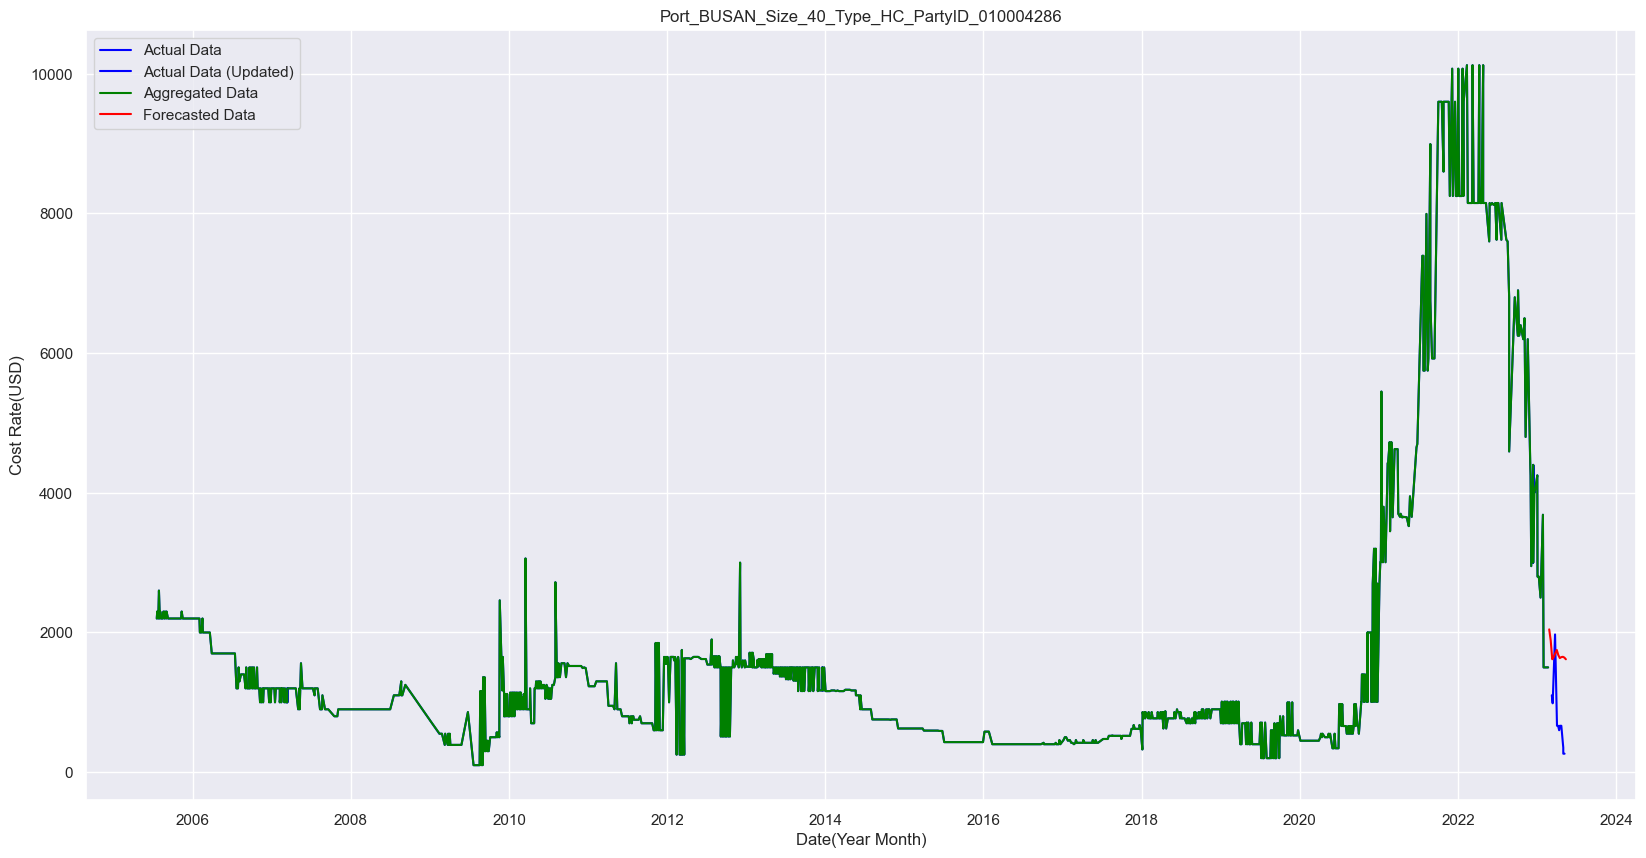

In [109]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(new_dates_df['POD'], new_dates_df['RATE'], color='blue', label="Actual Data (Updated)")

plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();